# Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.model_selection import train_test_split

# !pip install tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from yellowbrick.classifier.rocauc import roc_auc
import joblib
import matplotlib.pyplot as plt

# !pip install nltk
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
# nltk.download('omw-1.4')

# Read cleaned data

In [2]:
final_df=pd.read_csv('FinalData.csv')

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87048 entries, 0 to 87047
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     87043 non-null  object
 1   Emotion  87048 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
final_df.isna().sum()

Text       5
Emotion    0
dtype: int64

In [5]:
final_df=final_df.dropna()

'sad': 0,
    'angry': 1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'disgust':5

In [6]:
final_df.Emotion.value_counts()

0    16186
3    15854
1    14316
2    13996
4    13738
5    12953
Name: Emotion, dtype: int64

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87043 entries, 0 to 87047
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     87043 non-null  object
 1   Emotion  87043 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


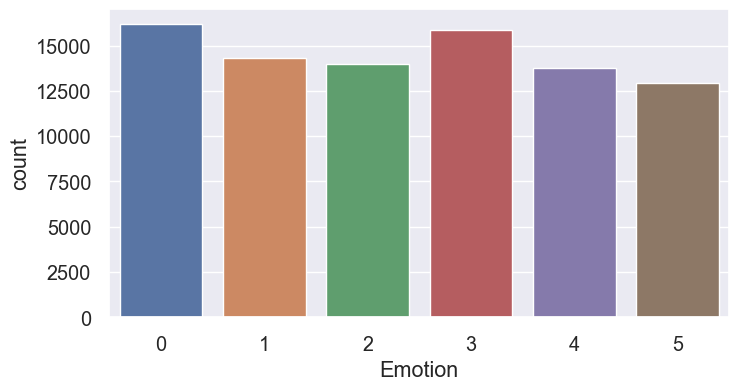

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=final_df);

# Split and training

In [9]:
x_train,x_test,y_train,y_test=train_test_split(final_df['Text'],final_df['Emotion'],test_size=0.20,shuffle=True,random_state=42)

In [10]:
type(final_df['Text'])

pandas.core.series.Series

In [12]:
def train_model(model, data, targets, x_test, y_test):
    text_clf = Pipeline([('vect', TfidfVectorizer()),
                        ('clf', model)])

    text_clf.fit(data, targets)
    roc_auc_score = roc_auc(text_clf, 
                            data, 
                            targets,
                            X_test=x_test, y_test=y_test,
                            classes=['0', '1', '2', '3', '4','5']
                            )
#     print(roc_auc_score)
    return text_clf,roc_auc_score


In [73]:
# SVM,curve1 = train_model(OneVsRestClassifier(SVC(kernel='sigmoid',random_state = 0,probability=True)), x_train, y_train,x_test,y_test)

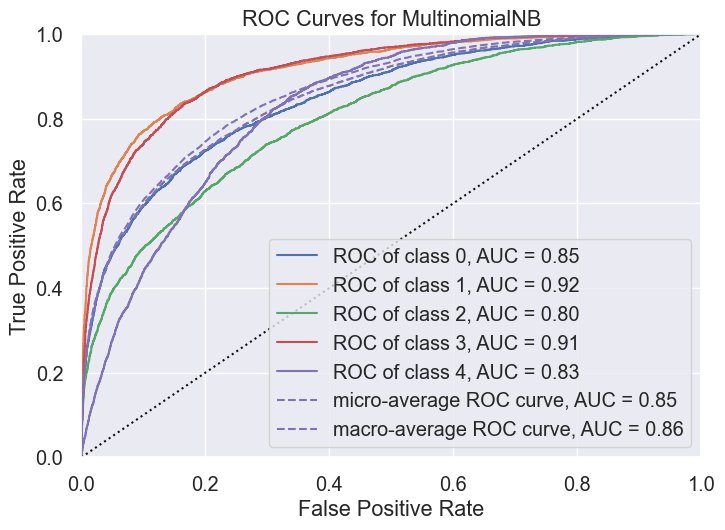

C:\Users\dongo\anaconda\envs\new\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dongo\anaconda\envs\new\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

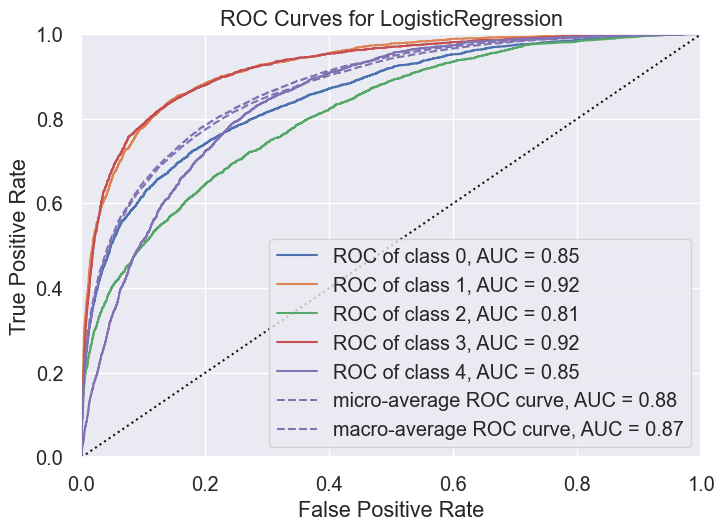

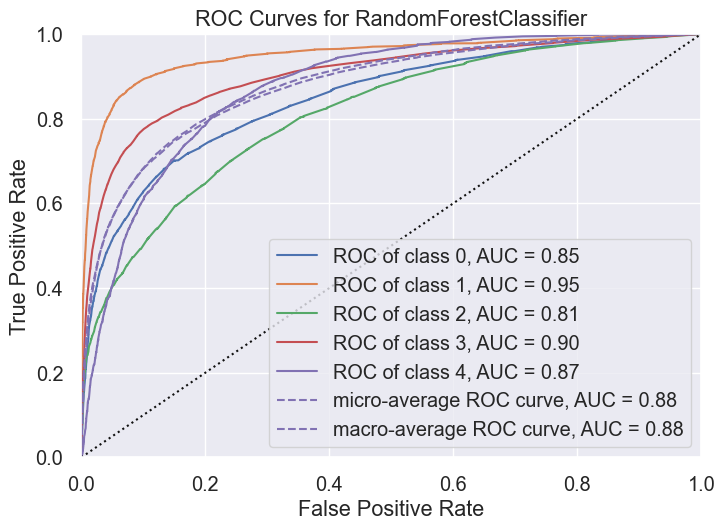

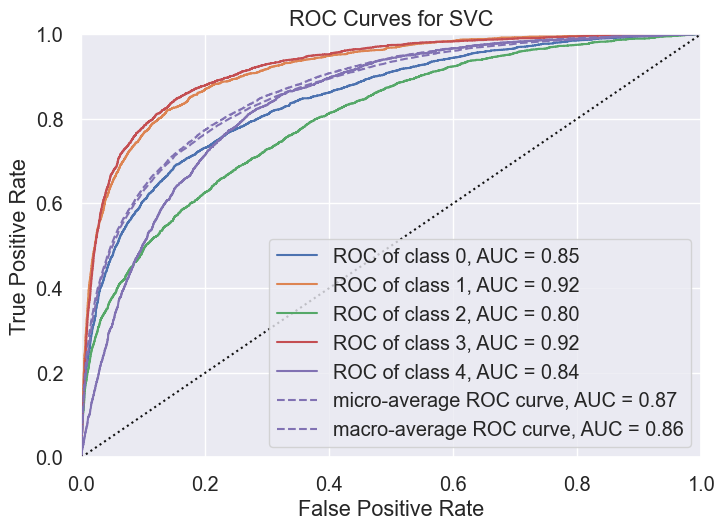

In [74]:
from sklearn.naive_bayes import MultinomialNB

models = [('Naive_Bayes', MultinomialNB()),
         ('LogReg',LogisticRegression(random_state=0,multi_class="multinomial", solver="lbfgs",max_iter=800)),
          ('Random_Forest', RandomForestClassifier(random_state = 0)),
         ('SVM',SVC(kernel='sigmoid',random_state = 0,probability=True))]

for name, model in models:
    model,roc=train_model(model, x_train, y_train,x_test,y_test)
    filename = name+'.sav'
    joblib.dump(model,filename)

In [ ]:
# def train_model2(model, data, targets, x_test, y_test):
#     text_clf = Pipeline([('vect', TfidfVectorizer()),
#                         ('clf', model)])

#     text_clf.fit(data, targets)
    
#     return text_clf


In [13]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=models,voting ='soft')
ensemble,roc=train_model(ensemble, x_train, y_train,x_test,y_test)

In [79]:
filename = 'ensemble.sav'
joblib.dump(ensemble[0],filename)

['ensemble.sav']

# Stacking

In [36]:
# from sklearn.metrics import mean_squared_error
# from vecstack import stacking

# model_1 = LogisticRegression(multi_class ='multinomial',max_iter = 800)
# model_2 = SVC(kernel='sigmoid',random_state = 0,probability=True)
# model_3 = RandomForestClassifier(random_state = 0)
 
# # putting all base model objects in one list
# all_models = [model_1, model_2, model_3]
 
# # computing the stack features
# s_train, s_test = stacking(all_models, x_train, x_test,
#                            y_train, regression=True, n_folds=4)
 
# # initializing the second-level model
# final_model = model_1
 
# # fitting the second level model with stack features
# final_model= train_model2(final_model, s_train, y_train,x_test,y_test)
 
# # predicting the final output using stacking
# pred_final = final_model.predict(x_test)
 
# # printing the mean squared error between real value and predicted value
# print(mean_squared_error(y_test, pred_final))

ValueError: could not convert string to float: 'weirdo gone'